In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, concatenate
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [14]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from preprocessing import TextPreprocessOld

srcLang = "eng"
tgtLang = "fra"
src_vocab_size = 20000
src_len = 150
tgt_vocab_size = 20000
tgt_len = 150
train_data_dir = "/linguistics/ethan/DL_Prototype/datasets/TQA/train"
test_tb_data_dir = "/linguistics/ethan/DL_Prototype/datasets/TQA/test/TB_test"
test_tm_data_dir = "/linguistics/ethan/DL_Prototype/datasets/TQA/test/TM_test"

label_class_map = {"good": 1, "bad": 0}
tp = TextPreprocessOld(srcLang, tgtLang, src_vocab_size=src_vocab_size, src_len=src_len,
                    tgt_vocab_size=tgt_vocab_size, tgt_len=tgt_len)
train_src_integers, train_tgt_integers, train_labels = tp.read_dataset_from_directory(train_data_dir, label_class_map)
test_tb_src_integers, test_tb_tgt_integers, test_tb_labels = tp.read_dataset_from_directory(test_tb_data_dir, label_class_map)
test_tm_src_integers, test_tm_tgt_integers, test_tm_labels = tp.read_dataset_from_directory(test_tm_data_dir, label_class_map)

# remove samples in training data that could exist in test data.
test_data = set(zip(test_tm_src_integers, test_tm_tgt_integers, test_tm_labels)).union(
            set(zip(test_tb_src_integers, test_tb_tgt_integers, test_tb_labels)))
train_data = set(zip(train_src_integers, train_tgt_integers, train_labels))
train_data = train_data.difference(test_data)

train_src_integers = np.array([td[0] for td in train_data])
train_tgt_integers = np.array([td[1] for td in train_data])
train_labels = np.array([td[2] for td in train_data])

print("Final number of training samples: {}".format(train_src_integers.shape[0]))
del train_data, test_data


Importing Data
	5 pairs of good English-French files found.
	9 pairs of bad English-French files found.
Importing Data Complete.
	352872 good entries
	417208 bad entries

Importing Data
	1 pairs of good English-French files found.
	1 pairs of bad English-French files found.
Importing Data Complete.
	400 good entries
	400 bad entries

Importing Data
	1 pairs of good English-French files found.
	1 pairs of bad English-French files found.
Importing Data Complete.
	400 good entries
	400 bad entries
Final number of training samples: 765175


In [3]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=2)
test_tm_labels = tf.keras.utils.to_categorical(test_tm_labels, num_classes=2)
test_tb_labels = tf.keras.utils.to_categorical(test_tb_labels, num_classes=2)

In [19]:
# sample 100 good labeled and 100 bad labeled TM
import pandas as pd
output = "/linguistics/ethan/DL_Prototype/datasets/train_sample/bad_tm.sample.xlsx"
good_tm = []
bad_tm = []
for src, tgt, label in zip(train_src_integers, train_tgt_integers, train_labels):
    if len(bad_tm) == 100:
        break
    if label == 0:
        bad_tm.append((src, tgt))
df = pd.DataFrame(bad_tm, columns=["English", "French"])
df.to_excel(output, header=True, index=None)
# train_tgt_integers[:10]

In [3]:
# check if test data has TM which also exists in training data
# test_data = set(zip(test_tm_src_integers, test_tm_tgt_integers, test_tm_labels))
# train_data = set(zip(train_src_integers, train_tgt_integers, train_labels))
# train_data = train_data.difference(test_data)
# next(iter(train_data))

In [10]:
# intersect_sources = [p[0] for p in intersect_data]
# train_src_integers, train_tgt_integers, train_labels
# np.where(test_tm_src_integers in intersect_sources, True, False)
# a = np.array(["1","2","3","4"])
# b = np.array(["1","2","5","4", "6"])
# (np.in1d(a, b))
# sum(np.in1d(test_tm_src_integers, train_src_integers))
# new_train_src_integers, new_train_tgt_integers, new_train_labels = [], [], []
# for s, t, l in zip(train_src_integers, train_tgt_integers, train_labels):
#     if (s not in test_tm_src_integers) and (t not in test_tm_tgt_integers):
#         new_train_src_integers.append(s)
#         new_train_tgt_integers.append(t)
#         new_train_labels.append(l)
# len(set(zip(train_src_integers, train_tgt_integers, train_labels)))
# train_src_integers.shape[0]

In [4]:
preprocessor_dir = "/linguistics/ethan/DL_Prototype/models/universal-sentence-encoder-cmlm_multilingual-preprocess_2"
LaBSE_dir = "/linguistics/ethan/DL_Prototype/models/LaBSE2_encoder"

In [14]:
# Text vectorization using pretrained preprocessor.
with tf.device("/cpu:0"):
    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    
#     train_src_integers = preprocessor(train_src_integers)
#     train_tgt_integers = preprocessor(train_tgt_integers)

    test_src_integers = preprocessor(test_src_integers)
    test_tgt_integers = preprocessor(test_tgt_integers)

In [5]:
# train_src_integers["input_type_ids"].shape

In [6]:
encoder = hub.KerasLayer(LaBSE_dir, trainable=False)

In [5]:
"""Define TQC models with and without preprocessor layer as part of model."""

def normalize(embeds):
    l2_norm = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
    return embeds / l2_norm

def build_model(max_seq_len):

    # preprocessor = hub.KerasLayer(
    #     "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
    # encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2", trainable=False)
    
    src_word_ids = Input((max_seq_len,), dtype=tf.int32)
    src_mask_ids = Input((max_seq_len,), dtype=tf.int32)
    src_type_ids = Input((max_seq_len,), dtype=tf.int32)
    
    tgt_word_ids = Input((max_seq_len,), dtype=tf.int32)
    tgt_mask_ids = Input((max_seq_len,), dtype=tf.int32)
    tgt_type_ids = Input((max_seq_len,), dtype=tf.int32)
    
    src_x = {"input_word_ids": src_word_ids,
             "input_mask": src_mask_ids,
             "input_type_ids": src_type_ids}
    
    tgt_x = {"input_word_ids": tgt_word_ids,
             "input_mask": tgt_mask_ids,
             "input_type_ids": tgt_type_ids}
    
    src_x = encoder(src_x)["default"]
    tgt_x = encoder(tgt_x)["default"]
    
    src_x = tf.math.l2_normalize(src_x, axis=1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=1, epsilon=1e-12, name=None)
    
    # np.matmul(english_embeds, np.transpose(italian_embeds))
    x = tf.concat([src_x, tgt_x], axis=1)
    #  x = GlobalMaxPooling1D(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model([src_word_ids, src_mask_ids, src_type_ids, 
               tgt_word_ids, tgt_mask_ids, tgt_type_ids], output)
    #  model = Model([src_x, tgt_x], output)
    
    return model

def build_model_with_preprocessor(max_seq_len, preprocessor_dir, LaBSE_dir):
    
    src_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_src_text")
    tgt_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_tgt_text")

    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    encoder = hub.KerasLayer(LaBSE_dir, trainable=False)
    
    src_x = preprocessor(src_texts)
    tgt_x = preprocessor(tgt_texts)
    
    src_x = encoder(src_x)["default"]
    tgt_x = encoder(tgt_x)["default"]
    
    src_x = tf.math.l2_normalize(src_x, axis=1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=1, epsilon=1e-12, name=None)
    
    # np.matmul(english_embeds, np.transpose(italian_embeds))
    x = tf.concat([src_x, tgt_x], axis=1)
    #  x = GlobalMaxPooling1D(x)

    x = Dense(128, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model([src_texts, tgt_texts], output)
    
    return model


def build_model_with_preprocessor_and_lstm(max_seq_len, preprocessor_dir, LaBSE_dir, softmax=False):
    """Once softmax output layer is turned on, make sure to onehot encode labeled data to shape (n, num_classes)"""
    
    src_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_src_text")
    tgt_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_tgt_text")

    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    encoder = hub.KerasLayer(LaBSE_dir, trainable=False)
    
    src_x = preprocessor(src_texts)
    tgt_x = preprocessor(tgt_texts)
    
    src_x = encoder(src_x)["sequence_output"]
    tgt_x = encoder(tgt_x)["sequence_output"]
    
    # src_x = tf.math.l2_normalize(src_x, axis=-1, epsilon=1e-12, name=None)
    # tgt_x = tf.math.l2_normalize(tgt_x, axis=-1, epsilon=1e-12, name=None)
    
    # np.matmul(english_embeds, np.transpose(italian_embeds))
    # sequence_output = tf.concat([src_x, tgt_x], axis=-1)
    sequence_output = concatenate([src_x, tgt_x])
    
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = GlobalAveragePooling1D()(bi_lstm)
    max_pool = GlobalMaxPooling1D()(bi_lstm)
    concat = concatenate([avg_pool, max_pool])
    dropout = Dropout(0.3)(concat)
    
    x = Dense(2048, activation="relu")(dropout)
    x = Dense(512, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    
    if softmax:
        output = Dense(2, activation='softmax')(x)
        
    else:
        output = Dense(1, activation='sigmoid')(x)
    
    
    model = Model([src_texts, tgt_texts], output)
    
    return model

In [33]:
# embeds = tf.constant([[1,2,3,4], [1,2, 3, 4]], dtype=tf.float32)
# embeds / np.linalg.norm(embeds, 2, axis=1, keepdims=True)
# # embeds
# tf.math.l2_normalize(
#     embeds, axis=1, epsilon=1e-12, name=None
# )


In [35]:
x = Input((128,))
output = Dense(2, activation='softmax')(x)
# output = Dense(1, activation='sigmoid')(x)
model = Model(x, output)

model.summary()
x = tf.random.uniform((1,128))
model.predict(x)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 1 / np.sqrt(30)
# tf.keras.layers.Lambda(
#       lambda x: tf.nn.l2_normalize(x, axis=1))(embeds)
# tf.nn.l2_normalize(embeds, axis=1)

In [7]:
"""Specify training hyperparameters"""

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

gpu_devices = get_available_gpus()
epochs = 10
max_seq_len = 128
batch_size = 256
num_samples = len(train_labels)
steps_per_epoch = int(num_samples / batch_size)

In [12]:
# model = build_model(max_seq_len)
# model2 = build_model_with_preprocessor(max_seq_len, preprocessor_dir, LaBSE_dir)
model3 = build_model_with_preprocessor_and_lstm(max_seq_len, preprocessor_dir, LaBSE_dir, softmax=True)
# del model3
# model2.summary()

In [18]:
# model2.summary()
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# with mirrored_strategy.scope():
# for d in ["/gpu:0", "/gpu:1"]:
    
#     with tf.device(d):

#         model = build_model(max_seq_len)
#         model.compile(optimizer="adam",
#                       loss="binary_crossentropy",
#                       metrics=["accuracy"])
#         model.fit(x=[train_src_integers["input_word_ids"], train_src_integers["input_mask"], train_src_integers["input_type_ids"],
#                      train_tgt_integers["input_word_ids"], train_tgt_integers["input_mask"], train_tgt_integers["input_type_ids"]],
#                   y=train_labels,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   steps_per_epoch=steps_per_epoch,
#                   validation_split=0.1)

In [9]:
"""Start training session."""

# Specify checkpoint saving every epoch
checkpoint_path = "/linguistics/ethan/DL_Prototype/models/TQA_models/Multilingual-LaBSE-Bidirectional-LSTM_ckpts/training_job_7/tqc-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                              verbose=1,
                                              save_weights_only=False,
                                              save_freq='epoch') # Save weights, every epoch.

# Specify weights for each class, especially for imbalanced datasets.
# weights = compute_class_weight("balanced", np.unique(train_labels), train_labels)
# class_weight = dict(zip(np.unique(train_labels), weights))

# specify metrics during and after training.
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# for d in ["/gpu:0", "/gpu:1"]:
#     with tf.device(d):

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    #  model = build_model(max_seq_len)
    #  model2 = build_model_with_preprocessor(max_seq_len, preprocessor_dir, LaBSE_dir)
    model3 = build_model_with_preprocessor_and_lstm(max_seq_len, preprocessor_dir, LaBSE_dir, softmax=True)
    model3.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy", recall_m, precision_m])

    #  model2.save_weights(checkpoint_path.format(epoch=0))

    model3.fit(x=[train_src_integers, train_tgt_integers],
               y=train_labels,
               batch_size=batch_size,
               epochs=epochs,
               steps_per_epoch=steps_per_epoch,
               callbacks=[callback],
#                class_weight=class_weight,
               validation_split=0.1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1


InvalidArgumentError: 3 root error(s) found.
  (0) Invalid argument:  logits and labels must have the same first dimension, got logits shape [128,2] and labels shape [256]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /threading.py:917) ]]
	 [[div_no_nan_2/ReadVariableOp_1/_744]]
  (1) Invalid argument:  logits and labels must have the same first dimension, got logits shape [128,2] and labels shape [256]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /threading.py:917) ]]
	 [[div_no_nan_1/_763]]
  (2) Invalid argument:  logits and labels must have the same first dimension, got logits shape [128,2] and labels shape [256]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /threading.py:917) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_149053]

Function call stack:
train_function -> train_function -> train_function


In [7]:
# continue training from checkpoint
# checkpoint_path = "/linguistics/ethan/DL_Prototype/models/TQA_models/Multilingual-LaBSE-Bidirectional-LSTM_ckpts/tqc-0002.ckpt"
# new_model = tf.keras.models.load_model(checkpoint_path)
# assert_allclose(model.predict(x_train),
#                 new_model.predict(x_train),
#                 1e-5)

# fit the model
# checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.fit(x=[test_tm_src_integers, test_tm_tgt_integers],
#                y=test_tm_labels, epochs=3, batch_size=16, callbacks=callbacks_list)

In [20]:
type(train_labels)
type(train_src_integers)
model3

In [ ]:
"""Evalution on Test data."""

In [20]:
# Get predictions from trained model on test inputs.
# predictions = model.predict([test_src_integers["input_word_ids"], test_src_integers["input_mask"], test_src_integers["input_type_ids"],
#                              test_tgt_integers["input_word_ids"], test_tgt_integers["input_mask"], test_tgt_integers["input_type_ids"]])
tm_predictions = model3.predict([test_tm_src_integers, test_tm_tgt_integers])
tb_predictions = model3.predict([test_tb_src_integers, test_tb_tgt_integers])

tm_pred = [1 if p > 0.5 else 0 for p in tm_predictions]
tb_pred = [1 if p > 0.5 else 0 for p in tb_predictions]

print(confusion_matrix(test_tm_labels, tm_pred, labels=[1,0]))
print(confusion_matrix(test_tb_labels, tb_pred, labels=[1,0]))

[[320  80]
 [111 289]]
[[303  97]
 [103 297]]


In [21]:
# threshold = 0.3
def evaluate(predictions, true_labels):
    records = []
    for threshold in np.linspace(0.1, 0.9, num=9):
        pred = [1 if p > threshold else 0 for p in predictions]
        acc = accuracy_score(true_labels, pred)
        rec = recall_score(true_labels, pred, labels=[1, 0])
        pre = precision_score(true_labels, pred, labels=[1, 0])
        f1 = f1_score(true_labels, pred, labels=[1, 0])
        records.append((threshold, acc, rec, pre, f1))

    df = pd.DataFrame(records, columns=["Threshold", "Accuracy", "Recall", "Precision", "F1"])
    return df

evaluate(tm_predictions, test_tm_labels)
# evaluate(tb_predictions, test_tb_labels)

,Threshold,Accuracy,Recall,Precision,F1
0,0.1,0.73000,0.8625,0.681818,0.761589
1,0.2,0.74000,0.8350,0.701681,0.762557
2,0.3,0.75375,0.8225,0.723077,0.769591
3,0.4,0.75875,0.8175,0.731544,0.772137
4,0.5,0.76125,0.8000,0.742459,0.770156
5,0.6,0.76375,0.7825,0.754217,0.768098
6,0.7,0.75625,0.7500,0.759494,0.754717
7,0.8,0.76000,0.7300,0.776596,0.752577
8,0.9,0.75125,0.6800,0.793003,0.732167


In [64]:
cls_model_dir = "/linguistics/ethan/DL_Prototype/models/LaBSE2_based_tqc"
model.save(cls_model_dir)

In [3]:
"""Load complete trained model."""

# Load trained model weights for defined model.
cls_weights_dir = "/linguistics/ethan/DL_Prototype/models/TQA_models/Multilingual-LaBSE-Bidirectional-LSTM_ckpts/training_job_7/tqc-0005.ckpt"
model3.load_weights(cls_weights_dir)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

custom_objects={"recall_m": recall_m, "precision_m": precision_m}
cls_model_dir = "/linguistics/ethan/DL_Prototype/models/TQA_models/Multilingual-LaBSE-Bidirectional-LSTM_ckpts/tqc-0009.ckpt"
model3 = tf.keras.models.load_model(cls_model_dir, custom_objects)

In [41]:
# prediction = model3.predict()
# output = 
# new_model3 = tf.keras.Model(model3.inputs,
# dir(model3)
# input_array = np.array([[1,2], [3,4]])
# print(input_array.shape)
# dense_output = Dense(1, activation='sigmoid')(input_array)
# print(dense_output) 
# tf.where(dense_output > 0.5, 1, 0)
# dense_output = np.array([[0.2], [0.4], [0.6]])
# np.where(dense_output > 0.5, 1, 0)

In [47]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.BinaryAccuracy()
logits = np.array([[0.4, 0.6], [0.2, 0.8]])
targets = np.array([[1, 0], [0, 1]])
print(loss_fn(targets, logits, None))
print(accuracy_fn(targets, logits, None))
print(tf.nn.softmax(logits))

tf.Tensor(0.6799356937408447, shape=(), dtype=float64)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(
[[0.450166   0.549834  ]
 [0.35434369 0.64565631]], shape=(2, 2), dtype=float64)


In [13]:
def classify1(text_pairs, threshold=0.5):
    
    src_integers = preprocessor([p[0] for p in text_pairs])
    tgt_integers = preprocessor([p[1] for p in text_pairs])
    
    predictions = model.predict([src_integers["input_word_ids"], src_integers["input_mask"], src_integers["input_type_ids"],
                                 tgt_integers["input_word_ids"], tgt_integers["input_mask"], tgt_integers["input_type_ids"]])
    
    return [1 if p > threshold else 0 for p in predictions]

def classify2(text_pairs, threshold=0.5):
    
    return [1 if p > threshold else 0 for p in model3.predict(text_pairs)]

In [41]:
text_pairs = [("Poly Property Group Company Limited", 
               "Poly Property Group Company Limited"),
              
              ("Amazon also indicated that it has moved its AI plans from hype to reality.", 
               "Amazon a aussi indiqué que ses projets d’IA, jusqu’alors des mythes, étaient devenus réalité."),
              
              ("A regulation may not be made before the earliest of", 
               "Le règlement ne peut être pris avant le premier en date des jours suivants"),
             
              ("Nancy J. Kyle is a vice chairman and director of CGTC.",
               "Nancy J. Kyle est vice-présidente du conseil d’administration et")]

classify(text_pairs, threshold=0.5)

In [14]:
src_texts = tf.constant([ "Poly Property Group Company Limited",
                          "Amazon also indicated that it has moved its AI plans from hype to reality.", 
                          "A regulation may not be made before the earliest of",
                          "Nancy J. Kyle is a vice chairman and director of CGTC.",
                          "You can copy-paste"])

tgt_texts = tf.constant(["Poly Property Group Company Limited", 
                         "Amazon a aussi indiqué que ses projets d’IA, jusqu’alors des mythes, étaient devenus réalité.",
                         "Le règlement ne peut être pris avant le premier en date des jours suivants",
                         "Nancy J. Kyle est vice-présidente du conseil d’administration et",
                         "Il est possible de copier-coller"])

["Poly Property Group Company Limited", "Amazon a aussi indiqué que ses projets d’IA, jusqu’alors des mythes, étaient devenus réalité.", "Le règlement ne peut être pris avant le premier en date des jours suivants", "Nancy J. Kyle est vice-présidente du conseil d’administration et", "Il est possible de copier-coller"]
classify2([src_texts, tgt_texts])

[1, 1, 0, 0, 0]

In [13]:
# model2.predict([src_texts, tgt_texts])
model3.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_src_text (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
input_tgt_text (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           input_src_text[0][0]             
                                                                 input_tgt_text[0][0]             
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 470926849   keras_layer[0][0]     

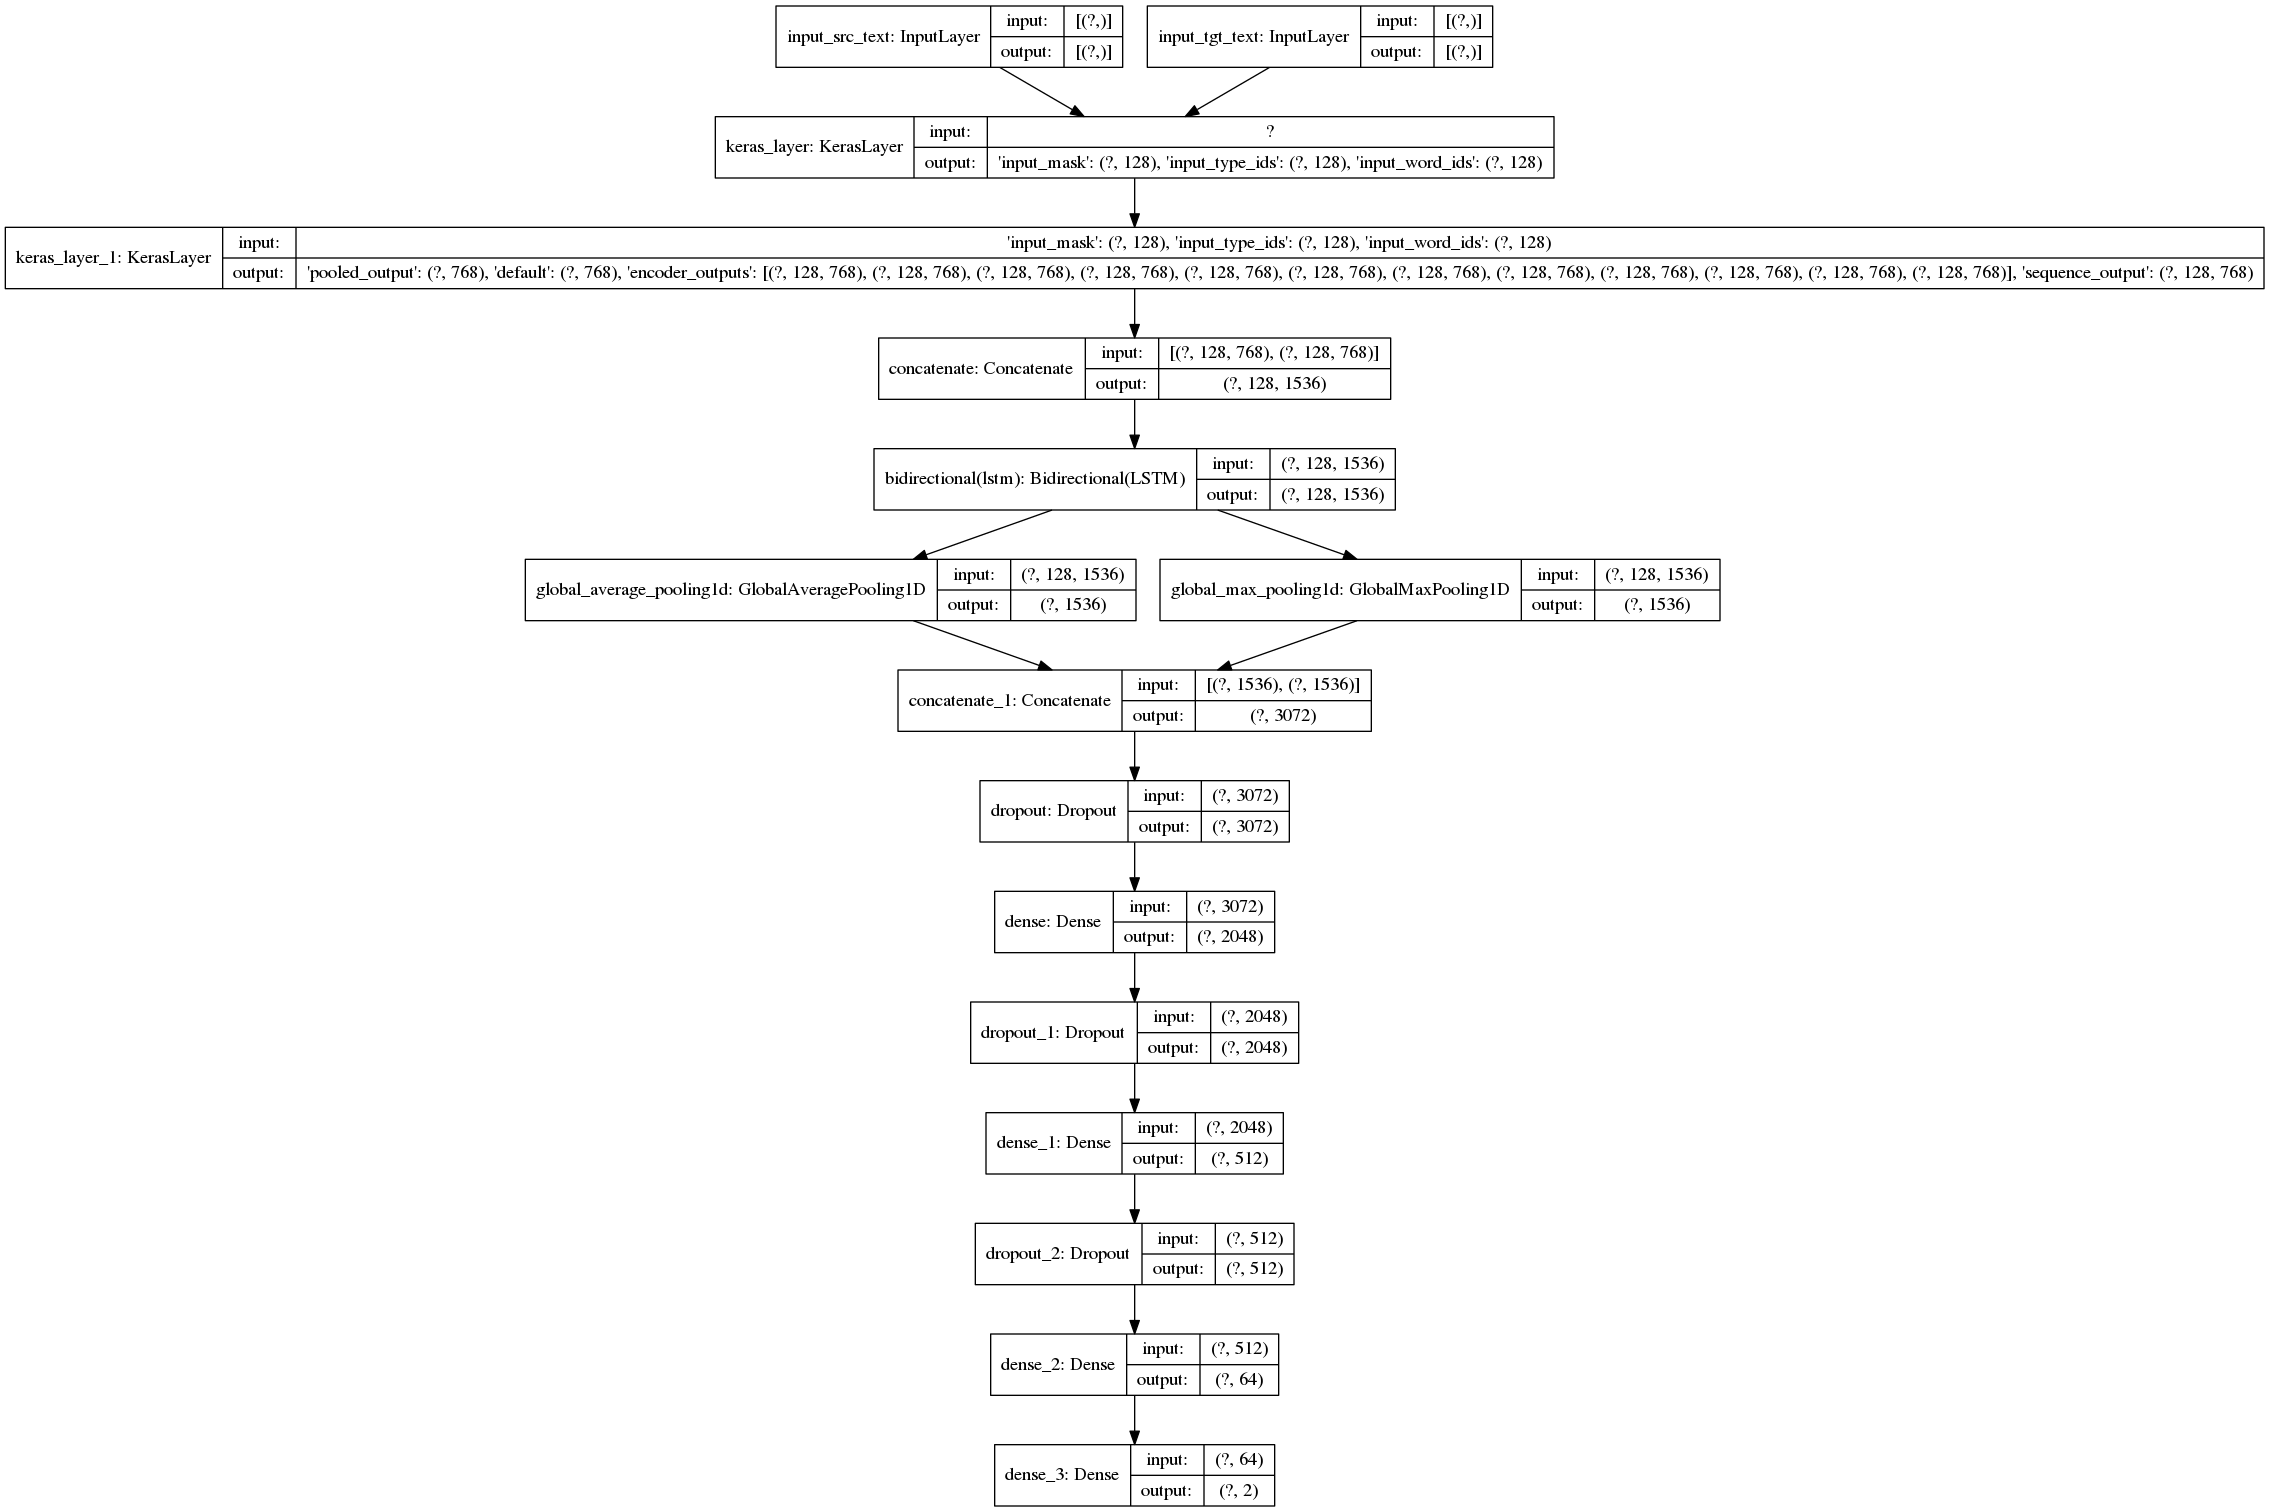

In [15]:
tf.keras.utils.plot_model(model3, "/linguistics/ethan/DL_Prototype/models/TQA_models/Multilingual-LaBSE-Bidirectional-LSTM_ckpts/training_job_7/LaBSE_bi-LSTM_based.softmax.png", show_shapes=True)